In [39]:
import os
import cv2
import torch
import numpy as np
import torchvision.models as models
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import precision_recall_fscore_support as prf
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
import torchvision.transforms as transforms

In [2]:
def getHOG() : 
    winSize = (128,64)
    blockSize = (16,16)
    blockStride = (8,8)
    cellSize = (8,8)
    nbins = 9
    derivAperture = 1
    winSigma = -1.
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 1
    nlevels = 64
    signedGradient = True

    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, signedGradient)

    return hog

In [7]:
def createDataTarget(hog):
    data = []
    target = []
    folders = ['./Data/Positive', './Data/Negative']
    for folder in folders:
        imgs = os.listdir(folder)
        for img in imgs:
            this_img = cv2.imread(folder+'/'+img)
            this_img = cv2.resize(this_img, (128, 64), interpolation=cv2.INTER_CUBIC)
            this_img = cv2.cvtColor(this_img, cv2.COLOR_BGR2RGB)
            descriptor = hog.compute(this_img)
            data.append(np.array(descriptor).ravel())
            target.append(1 if folder=='./Data/Positive' else -1)
    return data, target

In [8]:
hog = getHOG()
data, target = createDataTarget(hog)
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, shuffle=True, random_state=40)

In [12]:
def runWithSVM():
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(prf(y_test, y_pred, average='binary'))
runWithSVM()

(0.975, 1.0, 0.9873417721518987, None)


In [15]:
def runWithNB():
    clf = MultinomialNB()
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(prf(y_test, y_pred, average='binary'))
runWithNB()

(0.865546218487395, 0.8803418803418803, 0.8728813559322035, None)


(0.8540772532188842, 0.8504273504273504, 0.8522483940042828, None)


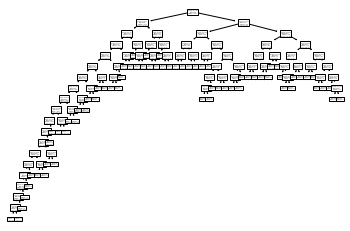

In [19]:
def runWithTree():
    clf = tree.DecisionTreeClassifier()
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(prf(y_test, y_pred, average='binary'))
    tree.plot_tree(clf) 
runWithTree()

**RUN WITH VGG19**

In [21]:
vgg19 = models.vgg19(pretrained=True, progress=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\NOKA/.cache\torch\checkpoints\vgg19-dcbb9e9d.pth


In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg19 = vgg19.to(device)
vgg19.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [40]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])

In [46]:
def createDataTargetVgg(model):
    data = []
    target = []
    folders = ['./Data/Positive', './Data/Negative']
    for folder in folders:
        imgs = os.listdir(folder)
        for img in imgs:
            with torch.no_grad():
                this_img = cv2.imread(folder+'/'+img)
                this_img = cv2.cvtColor(this_img, cv2.COLOR_BGR2RGB)
                this_img = transform(this_img)
                descriptor = model.features(this_img.unsqueeze(0).to(device)).flatten(start_dim=1)
                data.append(np.array(descriptor.cpu()).ravel())
            target.append(1 if folder=='./Data/Positive' else -1)
    return data, target

In [47]:
data, target = createDataTargetVgg(vgg19)
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, shuffle=True, random_state=40)

In [48]:
def runWithSVM():
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(prf(y_test, y_pred, average='binary'))
runWithSVM()

(0.975, 1.0, 0.9873417721518987, None)


In [51]:
def runWithNB():
    clf = MultinomialNB()
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(prf(y_test, y_pred, average='binary'))
runWithNB()

(0.9957446808510638, 1.0, 0.9978678038379531, None)


(0.9829059829059829, 0.9829059829059829, 0.9829059829059829, None)


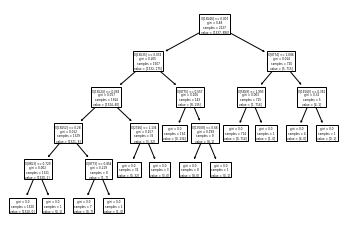

In [52]:
def runWithTree():
    clf = tree.DecisionTreeClassifier()
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(prf(y_test, y_pred, average='binary'))
    tree.plot_tree(clf) 
runWithTree()